In [6]:
import sys
import os
import pandas as pd # type: ignore
import numpy as np # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.cluster import KMeans # type: ignore
from scipy.stats import zscore # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
sys.path.append(os.path.abspath('C:/Users/nejat/AIM Projects/Telecommunication Data Analysis/src'))
from db_connection import PostgresConnection
from data_cleaning import preprocess_data  

def load_data():
    query = "SELECT * FROM xdr_data"
    db = PostgresConnection(dbname='tellco', user='postgres', password='237132')
    db.connect()
    result = db.execute_query(query)
    df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
    db.close_connection()
    print(df.head()) 
    return df

def aggregate_metrics(df):
    return df.groupby('MSISDN/Number').agg({
        'Dur. (ms)': 'sum',
        'Total DL (Bytes)': 'sum',
        'Total UL (Bytes)': 'sum',
        'Start': 'count'
    }).reset_index()

def get_top_customers(agg_df):
    top_10_sessions = agg_df.nlargest(10, 'Start')
    top_10_duration = agg_df.nlargest(10, 'Dur. (ms)')
    top_10_traffic = agg_df.nlargest(10, 'Total DL (Bytes)')
    
    return top_10_sessions, top_10_duration, top_10_traffic

def normalize_data(agg_df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(agg_df[['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Start']])
    return normalized_data

def apply_kmeans(normalized_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)
    return clusters, kmeans


df = load_data()
agg_df = aggregate_metrics(df)
top_10_sessions, top_10_duration, top_10_traffic = get_top_customers(agg_df)
print("Top 10 Customers by Session Frequency:\n", top_10_sessions)
print("\nTop 10 Customers by Session Duration:\n", top_10_duration)
print("\nTop 10 Customers by Total Download Traffic:\n", top_10_traffic)

normalized_data = normalize_data(agg_df)
clusters, kmeans = apply_kmeans(normalized_data)
agg_df['cluster'] = clusters


Connected to PostgreSQL database!
Connection closed.
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L7

C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster Statistics:
   cluster Dur. (ms)                                          Total DL (Bytes)  \
                min         max           mean           sum              min   
0       0    7142.0   1573420.0  105069.628307  8.327714e+09        8827082.0   
1       1   46896.0  18553754.0  566153.116046  2.371049e+09      525493344.0   
2       2   18235.0   3174824.0  210178.766116  4.920075e+09       76573361.0   

                                            Total UL (Bytes)               \
            max          mean           sum              min          max   
0  9.029696e+08  4.539128e+08  3.597667e+13        2866892.0  104979086.0   
1  8.156743e+09  2.058307e+09  8.620191e+12       78022976.0  729577380.0   
2  2.165972e+09  9.873437e+08  2.311273e+13       25897887.0  197644172.0   

                              Start                       
           mean           sum   min max      mean    sum  
0  4.162216e+07  3.298930e+12     1   2  1.019279  80787  
1  1.7705

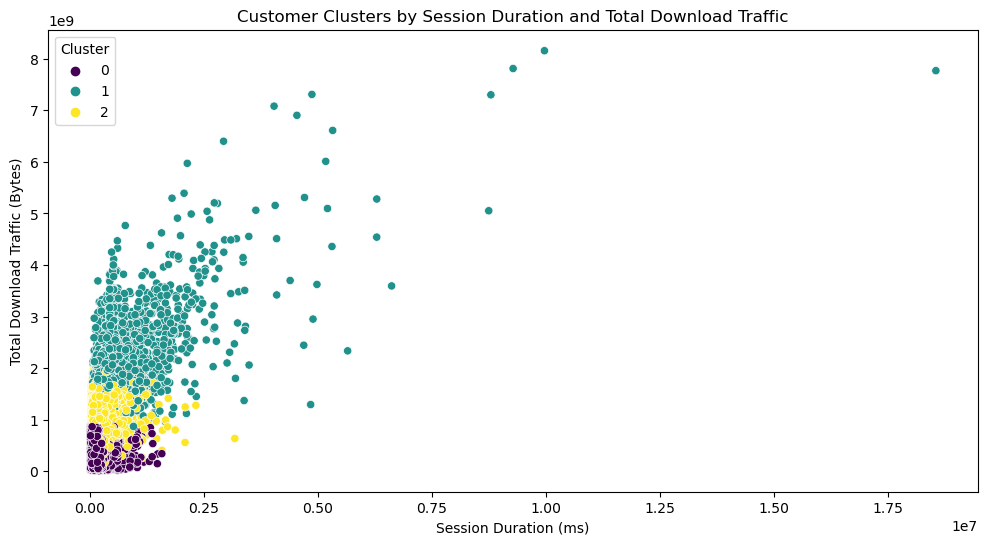

In [7]:
def compute_cluster_statistics(agg_df):
    cluster_stats = agg_df.groupby('cluster').agg({
        'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
        'Total DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Total UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Start': ['min', 'max', 'mean', 'sum']
    }).reset_index()
    return cluster_stats

def plot_clusters(agg_df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Dur. (ms)', y='Total DL (Bytes)', hue='cluster', data=agg_df, palette='viridis')
    plt.title('Customer Clusters by Session Duration and Total Download Traffic')
    plt.xlabel('Session Duration (ms)')
    plt.ylabel('Total Download Traffic (Bytes)')
    plt.legend(title='Cluster')
    plt.show()


cluster_stats = compute_cluster_statistics(agg_df)
print("\nCluster Statistics:\n", cluster_stats)
plot_clusters(agg_df)



Top 10 Most Engaged Users per Application:
 {'Social Media DL (Bytes)':    MSISDN/Number  Social Media DL (Bytes)  Youtube DL (Bytes)  \
0   3.362632e+10               42743837.0         164048706.0   
1   3.376054e+10               39297646.0         194068298.0   
2   3.365973e+10               34900444.0         119658146.0   
3   3.361489e+10               27749744.0         199823443.0   
4   3.362578e+10               26564121.0         237883033.0   
5   3.366716e+10               23753753.0         141972692.0   
6   3.378632e+10               23568655.0         118129859.0   
7   3.366907e+10               23477047.0         136295265.0   
8   3.360313e+10               22776679.0         158976704.0   
9   3.365849e+10               22695673.0          64799443.0   

   Netflix DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  Gaming DL (Bytes)  \
0         199479238.0        116106455.0        33404785.0       6.745734e+09   
1         146500839.0         88626532.0        2

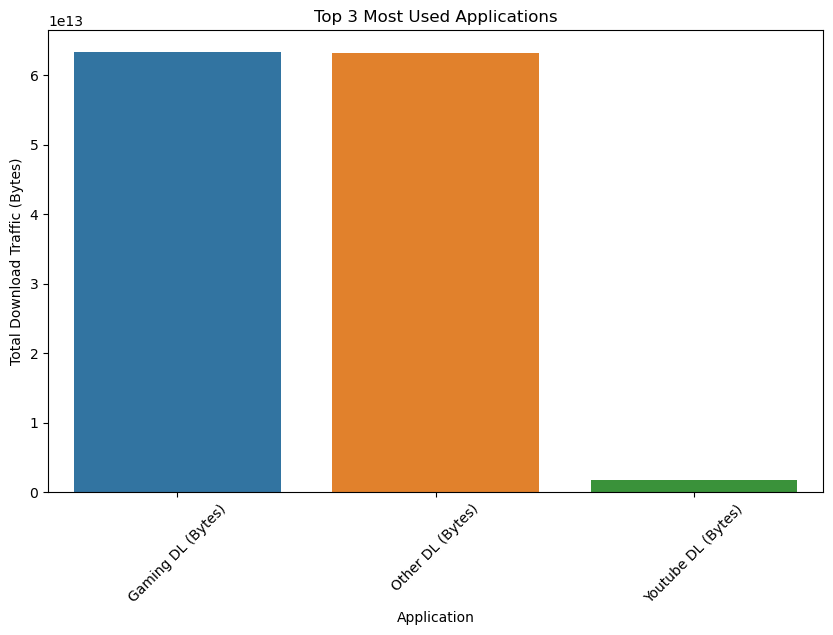

In [15]:
def aggregate_traffic_per_application(df):
    applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
                     'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
    
    app_traffic = df[['MSISDN/Number'] + applications].copy()
    app_traffic['Total DL (Bytes)'] = app_traffic[applications].sum(axis=1)
    
    aggregated = df.groupby('MSISDN/Number')[applications].sum().reset_index()
    
    top_users = {}
    for app in applications:
        top_users[app] = aggregated.nlargest(10, app).reset_index(drop=True)
    
    return top_users

def plot_top_applications(df):
    applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
                     'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
    

    app_usage = df[applications].sum().reset_index()
    app_usage.columns = ['Application', 'Total DL (Bytes)']
    
    top_3_apps = app_usage.nlargest(3, 'Total DL (Bytes)')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Application', y='Total DL (Bytes)', data=top_3_apps)
    plt.title('Top 3 Most Used Applications')
    plt.xlabel('Application')
    plt.ylabel('Total Download Traffic (Bytes)')
    plt.xticks(rotation=45)
    plt.show()


top_app_users = aggregate_traffic_per_application(df)
print("\nTop 10 Most Engaged Users per Application:\n", top_app_users)
plot_top_applications(df)


C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nejat\anaconda3\Lib\site-packages\sklearn\clust

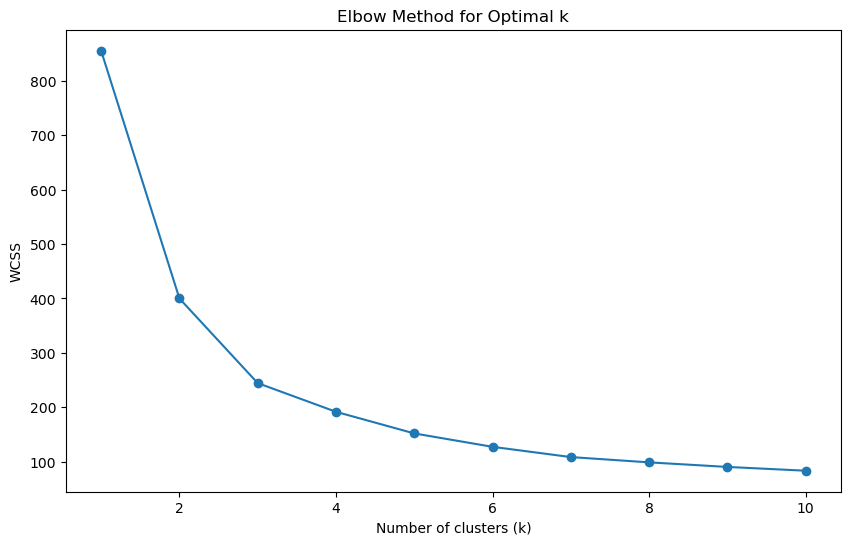

In [16]:
def elbow_method(normalized_data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(normalized_data)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

elbow_method(normalized_data)